This is the final lab!

Link to our online report: https://typst.app/project/wrwGc2UmM9BN9DHGm4aF2R

We can devide the task into:
1. Implement the Adaboost(DONE)
2. Generate the model selection procedure for Adaboost(Need to work on)
3. Document all the steps
4. Write the report

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import perceptron as pc
from sklearn.metrics import f1_score 


In [2]:
# Load the dataset
digits = load_digits()
X = digits.data
y = digits.target
# Print dataset details
print("Shape of data (features):", digits.data.shape)  # Feature matrix (n_samples, n_features)
print("Shape of images:", digits.images.shape)        # Images (n_samples, 8, 8)
print("Shape of target:", digits.target.shape)        # Labels (n_samples,)
print("Target classes:", np.unique(digits.target))    # Unique digit classes
'''
# Plot some example images with their labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Create a grid of 2x5
plt.suptitle("Example Digits Images with Labels")
for ax, idx in zip(axes.ravel(), range(10)):  # Iterate through first 10 images
    ax.imshow(digits.images[idx], cmap='gray')
    ax.set_title(f"Label: {digits.target[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Plot the distribution of the target labels
plt.figure(figsize=(8, 5))
plt.hist(digits.target, bins=np.arange(11) - 0.5, edgecolor='black')
plt.xticks(range(10))
plt.title("Distribution of Digits in Dataset")
plt.xlabel("Digit Label")
plt.ylabel("Count")
plt.show()

# Visualize the mean image of each digit
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
plt.suptitle("Mean Image of Each Digit")
for ax, digit in zip(axes.ravel(), range(10)):
    mean_image = digits.images[digits.target == digit].mean(axis=0)  # Compute mean image
    ax.imshow(mean_image, cmap='gray')
    ax.set_title(f"Digit: {digit}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Visualize pixel intensity histograms for all digits
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
plt.suptitle("Pixel Intensity Histograms for Each Digit")
for ax, digit in zip(axes.ravel(), range(10)):
    digit_data = digits.images[digits.target == digit].reshape(-1)  # Flatten all images of the digit
    ax.hist(digit_data, bins=20, color='blue', alpha=0.7)
    ax.set_title(f"Digit: {digit}")
    ax.set_xlim(0, 16)  # Pixel values range from 0 to 16
    ax.set_ylim(0, 500)
plt.tight_layout()
plt.show()
'''

Shape of data (features): (1797, 64)
Shape of images: (1797, 8, 8)
Shape of target: (1797,)
Target classes: [0 1 2 3 4 5 6 7 8 9]


'\n# Plot some example images with their labels\nfig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Create a grid of 2x5\nplt.suptitle("Example Digits Images with Labels")\nfor ax, idx in zip(axes.ravel(), range(10)):  # Iterate through first 10 images\n    ax.imshow(digits.images[idx], cmap=\'gray\')\n    ax.set_title(f"Label: {digits.target[idx]}")\n    ax.axis(\'off\')\nplt.tight_layout()\nplt.show()\n\n# Plot the distribution of the target labels\nplt.figure(figsize=(8, 5))\nplt.hist(digits.target, bins=np.arange(11) - 0.5, edgecolor=\'black\')\nplt.xticks(range(10))\nplt.title("Distribution of Digits in Dataset")\nplt.xlabel("Digit Label")\nplt.ylabel("Count")\nplt.show()\n\n# Visualize the mean image of each digit\nfig, axes = plt.subplots(2, 5, figsize=(10, 5))\nplt.suptitle("Mean Image of Each Digit")\nfor ax, digit in zip(axes.ravel(), range(10)):\n    mean_image = digits.images[digits.target == digit].mean(axis=0)  # Compute mean image\n    ax.imshow(mean_image, cmap=\'gray\'

In [3]:
from sklearn.model_selection import train_test_split


# Function to plot target value distributions
def plot_target_distribution(y, split_name):
    unique, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, color='skyblue', edgecolor='black')
    plt.xticks(unique)
    plt.title(f"Target Value Distribution in {split_name}")
    plt.xlabel("Digit Class")
    plt.ylabel("Count")
    plt.show()
    
def Accuracy(y_pred, y):
    '''
    OUTPUT :
    - accuracy: compare two outputs, calculate their accuracy
    '''
    val_accuracy = np.mean(y_pred == y)
    print(f"Testing Accuracy: {val_accuracy * 100:.2f}%")
    return val_accuracy

# Plot distributions for each split
#plot_target_distribution(y_train, "Training Set")
#plot_target_distribution(y_test, "Test Set")

In [4]:
# Split into train + test(The split of validation is in training session)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.11, random_state=12)

# Store the binary labels for all classes
binary_y_train = {}
binary_y_valid = {}
binary_y_test = {}

# Iterate over each digit (0 to 9)
for k in range(10):
    # Create binary labels for class k in training set
    y_train_k = np.copy(y_train)
    y_train_k[y_train_k != k] = -1  # Set all other classes to -1
    y_train_k[y_train_k == k] = 1   # Set class k to 1
    binary_y_train[k] = y_train_k
    
    # Create binary labels for class k in training set
    y_valid_k = np.copy(y_valid)
    y_valid_k[y_valid_k != k] = -1  # Set all other classes to -1
    y_valid_k[y_valid_k == k] = 1   # Set class k to 1
    binary_y_valid[k] = y_valid_k

    # Create binary labels for class k in test set
    y_test_k = np.copy(y_test)
    y_test_k[y_test_k != k] = -1  # Set all other classes to -1
    y_test_k[y_test_k == k] = 1   # Set class k to 1
    binary_y_test[k] = y_test_k


# Now binary_y_train[k], binary_y_valid and binary_y_test[k] contain the binary labels for digit k
# This split will maintain until the whole SAMME is trained


In [5]:
X_train.shape, X_valid.shape, X_test.shape

((1439, 64), (178, 64), (180, 64))

In [6]:
def Perceptron_train(alpha, epoch, weight_samples):
    '''
    Train Perceptron models for each class (One-vs-All) with weighted samples.

    INPUT:
    - alpha: Learning rate for the Perceptron
    - epoch: Number of epochs to train each weak classifier
    - weight_samples: Current weights for the training samples

    OUTPUT:
    - models: Dictionary of trained Perceptron models for each class
    - error: Combined weighted error across all classifiers
    - y_Pred: Predicted labels on the training data
    '''
    accuracy = {}
    f1s = {}
    models = {}

    # Iterate training over each digit (0 to 9)
    for k in range(10):
        print(f"Training Model for Class {k}")
        
        # Initialize Perceptron model
        model_k = pc.Perceptron(alpha)
        
        # Train the Perceptron on weighted samples
        model_k.train(X_train, X_valid, binary_y_train[k], binary_y_valid[k], weight_samples, epochs=epoch)
        
        # Evaluate model on test set
        y_pred = model_k.predict(X_test)
        accuracy[k] = model_k.accuracy(y_pred, binary_y_test[k])
        
        # Calculate F1 score
        precision, recall, f1 = model_k.precision_recall_f1(y_pred, binary_y_test[k])
        f1s[k] = f1  # Store F1 score
        models[k] = model_k  # Store trained model
        
        print(f"Class {k}: Accuracy = {accuracy[k]:.2f}, F1 = {f1:.2f}")
        print("~" * 20)

    # Calculate average accuracy and F1-score across all binary classifiers
    avg_accuracy = np.mean(list(accuracy.values()))
    avg_f1 = np.mean(list(f1s.values()))

    print("End performance:")
    print(f"Average Accuracy: {avg_accuracy * 100:.2f}%")
    print(f"Average F1-score: {avg_f1:.2f}")

    # Combine predictions for the multi-class task
    y_Testintrain = np.copy(y_train)  # Ground truth labels for training set
    fill_value = -1  # Placeholder for unclassified samples
    y_Pred = np.full_like(y_train, fill_value)  # Initialize predictions
    
    # Update predictions based on the reliability of models (using F1 scores)
    for k in range(10):
        y_pred_k = models[k].predict(X_train)
        y_Pred[(y_pred_k == 1) & (y_Pred == fill_value)] = k  # Assign if unclassified
        # Update predictions for conflicts based on F1 scores
        conflict_indices = np.where((y_pred_k == 1) & (y_Pred != fill_value))[0]
        for idx in conflict_indices:
            current_class = y_Pred[idx]  # Existing predicted class
            if f1s[k] > f1s[current_class]:  # Compare F1 scores
                y_Pred[idx] = k  # Update to more reliable prediction

    # Calculate combined model accuracy and F1-score
    combined_accuracy = Accuracy(y_Pred, y_Testintrain)
    combined_f1 = f1_score(y_Testintrain, y_Pred, average='macro')

    # Calculate the combined error for SAMME
    # Error is defined as the weighted sum of misclassified samples
    error = np.sum(weight_samples[y_Pred != y_Testintrain]) / np.sum(weight_samples)

    print(f"\nCombined Accuracy: {combined_accuracy * 100:.2f}%")
    print(f"Combined F1-score: {combined_f1:.2f}")
    print(f"Combined Weighted Error: {error:.4f}\n")
    
    return models, error, y_Pred, f1s

def Combined_predict(Models, X, Y, f1s):
    # Combine predictions for the multi-class task
    fill_value = -1  # Placeholder for unclassified samples
    y_Pred = np.full_like(Y, fill_value)  # Initialize predictions
    for k in range(10):
        y_pred_k = Models[k].predict(X)
        y_Pred[(y_pred_k == 1) & (y_Pred == fill_value)] = k  # Assign if unclassified
        # Update predictions for conflicts based on F1 scores
        conflict_indices = np.where((y_pred_k == 1) & (y_Pred != fill_value))[0]
        for idx in conflict_indices:
            current_class = y_Pred[idx]  # Existing predicted class
            if f1s[k] > f1s[current_class]:  # Compare F1 scores
                y_Pred[idx] = k  # Update to more reliable prediction
    return y_Pred

def SAMME_predict_optimized(Weak_classifier_perceptrons, X_valid, y_valid, weight_Weak_classifier, F1s, n_classes=10):
    """
    Perform SAMME prediction by combining weighted votes from weak classifiers efficiently.

    """
    n_samples = X_valid.shape[0]
    votes = np.zeros((n_samples, n_classes))  # Accumulate votes for each class

    for t in range(len(Weak_classifier_perceptrons)):
        # Predict for all samples at once using the weak classifiers
        predictions_t = Combined_predict(Weak_classifier_perceptrons[t], X_valid, y_valid, F1s[t])
        valid_indices = predictions_t != -1  # Only count valid predictions

        # Update votes for valid predictions
        votes[valid_indices, predictions_t[valid_indices]] += weight_Weak_classifier[t]

    # Final prediction: the class with the most votes
    y_pred = np.argmax(votes, axis=1)

    # Evaluate final model
    accuracy = np.mean(y_pred == y_valid)
    f1 = f1_score(y_valid, y_pred, average='macro')
    print(f"Final SAMME Accuracy: {accuracy * 100:.2f}%")
    print(f"Final SAMME F1-score: {f1:.2f}")
    
    return y_pred, accuracy, f1

In [7]:
#training--here we should implement SAMME
alpha=0.01 #learning rate
epoch = 10 # epoches to train a weak classifier
T = 5 # the weak classifier number
K = 5 # K-fold number
weight_Weak_classifier = {} # weight for weak classifier
weight_samples = {} # weight for samples
Weak_classifier_perceptrons = {} # collection of trained and combined one vs all perceptron models
# innitial weights
n_samples = len(y_train)
weight_samples = np.ones(n_samples) / n_samples
n_classes = 10
F1s = {}

#SAMME training start
for t in range(T):
    
    Models_temp, Error, y_Pred, f1s = Perceptron_train(alpha, epoch, weight_samples)
    if Error >= 0.5:
            print("Classifier has high error; skipping this round.\n")
            continue
    F1s[t] = f1s
    Weak_classifier_perceptrons[t] = Models_temp
    weight_Weak_classifier[t] = np.log((1 - Error) / Error) + np.log(n_classes - 1)
    
    # update the sample weights
    for i in range(n_samples):
        class_predictions = y_Pred
        correct_class = y_train[i]
        prediction_weight = sum(
            weight_Weak_classifier[j] * (class_predictions[j] != correct_class)
            for j in range(len(Weak_classifier_perceptrons))
        )
        weight_samples[i] *= np.exp(prediction_weight)
        
    # Normalize sample weights
    weight_samples /= np.sum(weight_samples)
    print(f"Weak Classifier {t+1} Trained.")
    
# SAMME trained

y_pred, accuracy, f1 = SAMME_predict_optimized(Weak_classifier_perceptrons, X_valid, y_valid, weight_Weak_classifier, F1s)


Training Model for Class 0
Validation Accuracy: 100.00%
Validation precision: 100.00%
Validation recall: 100.00%
Validation f1_score: 1.00
Testing Accuracy: 100.00%
Testing precision: 100.00%
Testing recall: 100.00%
Testing f1_score: 1.00
Class 0: Accuracy = 1.00, F1 = 1.00
~~~~~~~~~~~~~~~~~~~~
Training Model for Class 1
Validation Accuracy: 97.19%
Validation precision: 82.61%
Validation recall: 95.00%
Validation f1_score: 0.88
Testing Accuracy: 97.78%
Testing precision: 84.21%
Testing recall: 94.12%
Testing f1_score: 0.89
Class 1: Accuracy = 0.98, F1 = 0.89
~~~~~~~~~~~~~~~~~~~~
Training Model for Class 2
Validation Accuracy: 99.44%
Validation precision: 95.65%
Validation recall: 100.00%
Validation f1_score: 0.98
Testing Accuracy: 100.00%
Testing precision: 100.00%
Testing recall: 100.00%
Testing f1_score: 1.00
Class 2: Accuracy = 1.00, F1 = 1.00
~~~~~~~~~~~~~~~~~~~~
Training Model for Class 3
Validation Accuracy: 97.75%
Validation precision: 90.00%
Validation recall: 90.00%
Validation

In [8]:
y_pred, accuracy, f1 = SAMME_predict_optimized(Weak_classifier_perceptrons, X_test, y_test, weight_Weak_classifier, F1s)


Final SAMME Accuracy: 86.11%
Final SAMME F1-score: 0.87


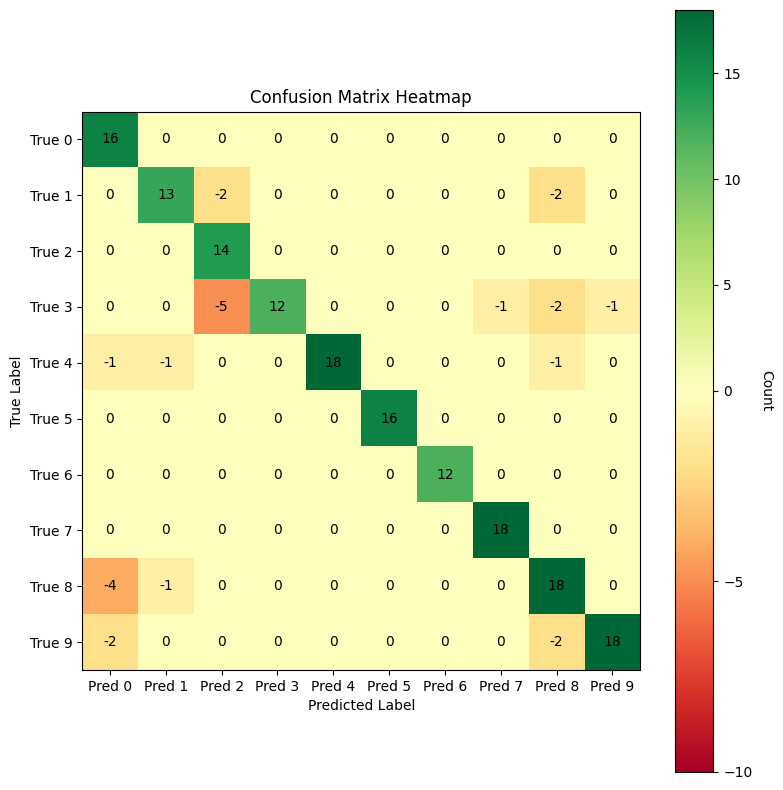

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Recreating the confusion matrix for visualization (adjust as needed for real data)
confusion_matrix = np.zeros((10, 10))
for t, p in zip(y_test, y_pred):
    if t==p:
        confusion_matrix[t, p] += 1
    if t!=p:
        confusion_matrix[t, p] -= 1

# Setting up the color map with white at 0, red for negatives, green for positives
norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=confusion_matrix.max())
cmap = plt.cm.RdYlGn

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(confusion_matrix, cmap=cmap, norm=norm)

# Adding color bar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Count", rotation=270, labelpad=15)

# Labeling the axes
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels([f"Pred {i}" for i in range(10)])
ax.set_yticklabels([f"True {i}" for i in range(10)])

# Adding annotations
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, int(confusion_matrix[i, j]),
                       ha="center", va="center",
                       color="black")

# Adding gridlines for better visualization
ax.set_title("Confusion Matrix Heatmap")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.tight_layout()
plt.show()
